In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek  # Menggunakan SMOTE-Tomek (Hybrid)
from sklearn.preprocessing import RobustScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("dataset.csv")
df.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
df['Gender_Encoded'] = df['Gender'].map({'Female': 0, 'Male': 1})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             566 non-null    int64  
 1   Gender          566 non-null    object 
 2   TB              566 non-null    float64
 3   DB              566 non-null    float64
 4   Alkphos         566 non-null    int64  
 5   Sgpt            566 non-null    int64  
 6   Sgot            566 non-null    int64  
 7   TP              566 non-null    float64
 8   ALB             566 non-null    float64
 9   A/G Ratio       566 non-null    float64
 10  Selector        566 non-null    int64  
 11  Gender_Encoded  566 non-null    int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 53.2+ KB


In [5]:
df = df.drop(columns=['Gender'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             566 non-null    int64  
 1   TB              566 non-null    float64
 2   DB              566 non-null    float64
 3   Alkphos         566 non-null    int64  
 4   Sgpt            566 non-null    int64  
 5   Sgot            566 non-null    int64  
 6   TP              566 non-null    float64
 7   ALB             566 non-null    float64
 8   A/G Ratio       566 non-null    float64
 9   Selector        566 non-null    int64  
 10  Gender_Encoded  566 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 48.8 KB


In [7]:
X = df.drop(columns=['Selector'])
y = df["Selector"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
import pandas as pd

# 1. Tentukan kolom mana yang mau di-scale (Semua KECUALI 'Gender')
# Kita ambil nama semua kolom, lalu buang 'Gender' dari list
cols_to_scale = [col for col in X_train.columns if col != 'Gender']

# 2. Siapkan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num',          RobustScaler(),    cols_to_scale)
    ],
    remainder='passthrough',  # PENTING: Kolom sisa ('Gender') dibiarkan lewat tanpa diubah
    verbose_feature_names_out=False # Agar nama kolom tidak berubah jadi aneh (misal: num__Age)
).set_output(transform="pandas") # FITUR BARU: Output langsung jadi DataFrame (bukan array)

# 3. Terapkan pada Data
# fit_transform pada Train
X_train_scaled = preprocessor.fit_transform(X_train)

# transform saja pada Test
X_test_scaled = preprocessor.transform(X_test)

# Cek hasil
print("Preview Data (Gender tidak berubah, yang lain berubah):")
print(X_train_scaled.head())

Preview Data (Gender tidak berubah, yang lain berubah):
          Age      TB   DB   Alkphos      Sgpt      Sgot        TP       ALB  \
107  0.192308  3.0000  2.7  3.713115  4.082759  4.179487 -0.641509 -0.727273   
381 -0.269231 -0.1250 -0.1  0.000000 -0.220690  0.162393  0.415094  0.545455   
182  0.153846  0.6250  0.3  0.008197  0.413793 -0.145299 -0.641509 -0.090909   
296 -0.576923 -0.1250 -0.1 -0.409836 -0.220690 -0.316239  1.018868  1.272727   
277 -0.846154  0.0625  0.2 -0.139344  0.110345  0.008547  0.867925  1.090909   

     A/G Ratio  Gender_Encoded  
107     -0.675             0.0  
381      0.150             0.0  
182      0.400             0.0  
296      0.900            -1.0  
277      0.650             0.0  


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# base learners
xgb = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1.0,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",     # cepat; kalau GPU bisa: "gpu_hist"
    n_jobs=-1,
    random_state=42,
)

lgbm = LGBMClassifier(
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="binary",
    random_state=42,
    n_jobs=-1,
)

cat = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.03,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=False
)

estimators = [
    ("xgb", xgb),
    ("lgbm", lgbm),
    ("cat", cat),
]

# meta learner (umum & kuat)
meta = LogisticRegression(max_iter=5000)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=meta,
    stack_method="predict_proba",  # gunakan probabilitas
    cv=cv,
    n_jobs=-1,
    passthrough=False              # True kalau mau fitur asli ikut meta-learner
)

stack.fit(X_train_scaled, y_train)

proba = stack.predict_proba(X_test_scaled)[:, 1]
pred = (proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, pred))
print("ROC-AUC :", roc_auc_score(y_test, proba))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 323, number of negative: 129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 452, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.714602 -> initscore=0.917840
[LightGBM] [Info] Start training from score 0.917840
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

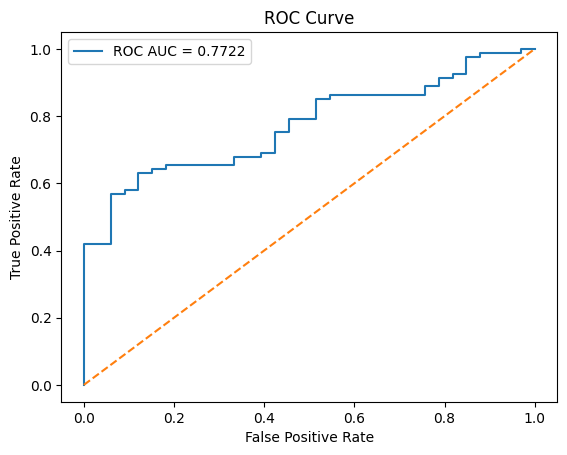

In [12]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

plot_roc_curve(y_test, proba)
